# MLVC Exercise 3

This notebook contains the third exercise of the Machine Learning for Visual Computing (193.189) lecture at TU Wien. Assignment via TUWEL. Please be aware of the deadlines in TUWEL.

* Upload a zip-file with the required programms. The programming language is python. 
    1. Self-Attention --> `solutions/self_attention.py`
    2. Vision Transformer --> `solutions/vision_transformer.py`
    3. Masked Autoencoder --> `solutions/masked_autoencoder.py`
* If you needed additional conda or pip packages add an anaconda environment.yml to the zip-file
    1. conda env export > environment.yml
    2. See --> https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#sharing-an-environment

### Conda instructions

1. conda create --name MLVC python=3.11
2. conda activate MLVC
3. Install the correct version of pytorch:
    - CPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cpu
    - GPU: python -m pip install torch torchvision --index-url https://download.pytorch.org/whl/cu129
4. python -m pip install pillow matplotlib tqdm torchinfo pandas ipykernel nbformat ipywidgets scikit-learn tabulate seaborn umap-learn cvxopt
5. Add python kernel to Jupyter Notebooks
    - python -m ipykernel install --user --name MLVC --display-name "Python (mlvc)”

### Note 1: You may reuse the conda environments for all exercises!
### Note 2: You may also use different package managers (e.g. pip, mamba, ...)!
### Note 3: You do not need to exactly match the expected results: similar performance is sufficient.

### **Please update your group number in the filename (_X) and only upload your solutions folder.**

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
from tabulate import tabulate
import seaborn as sns
import json
import random
import torch
from collections import OrderedDict
import umap
import torch.nn as nn

from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from torch.utils.data import DataLoader
from utils import pick_device, print_device_info

np.set_printoptions(suppress=True)

# General setting for the ipynb
NUM_SAMPLES = 10000  # Number of training samples that will be generated, do not exceed 25.000 on the TUWEL Jupyter Notebooks (will crash kernel)
TEST_RATIO = 0.9  # Percentage of the generated samples that are used for training (rest is used for testing). [0, 1]

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = pick_device()
print_device_info(device)
lr = 0.001
batch_size = 32
epochs = 10
d_model = 32
num_heads = 4

C:\Users\Acer\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using CPU


## Generate and Prepare Data

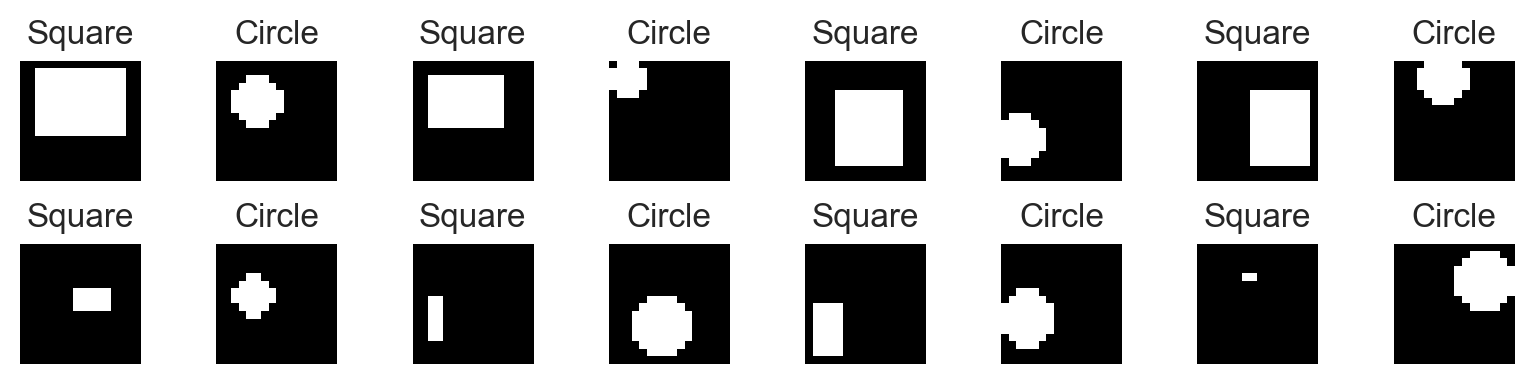

(9000, 256) (9000,) (1000, 256) (1000,)


In [2]:
# Generate the dataset using numpy and pillow

from utils import Dataset, TorchDataset

(dataset_train, labels_train), (dataset_test, labels_test) = Dataset(
    NUM_SAMPLES, TEST_RATIO
)

fig, axs = plt.subplots(2, 8, figsize=(8, 2), dpi=200)

for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow(dataset_train[i, :].reshape((16, 16)), cmap="gray")
    ax.set_title("Circle" if labels_train[i] == -1 else "Square")
    ax.axis("off")

plt.tight_layout()
plt.show()
print(dataset_train.shape, labels_train.shape, dataset_test.shape, labels_test.shape)

# Convert to PyTorch datasets and dataloaders

train_ds = TorchDataset(dataset_train, labels_train)
test_ds = TorchDataset(dataset_test, labels_test)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, drop_last=False)

## 1. Self-Attention

Implement Self-Attention

In [3]:
from solutions import MultiHeadSelfAttention

In [4]:
mhsa = MultiHeadSelfAttention(d_model=d_model, num_heads=num_heads).to(device)
print(mhsa)

MultiHeadSelfAttention(
  (q_proj): Linear(in_features=32, out_features=32, bias=True)
  (k_proj): Linear(in_features=32, out_features=32, bias=True)
  (v_proj): Linear(in_features=32, out_features=32, bias=True)
  (out_proj): Linear(in_features=32, out_features=32, bias=True)
)


Output shape: (1, 16, 32)
Max |y - x| = 1.720335  (smaller is better; increase alpha to make it smaller)


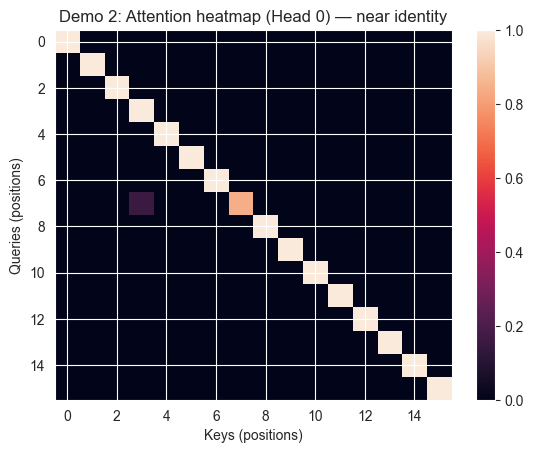

In [5]:
with torch.no_grad():
    # Make Q and K ~ alpha * I to emphasize self-similarity over cross-similarity
    alpha = 5.0
    mhsa.q_proj.weight.copy_(alpha * torch.eye(d_model))
    mhsa.q_proj.bias.zero_()
    mhsa.k_proj.weight.copy_(alpha * torch.eye(d_model))
    mhsa.k_proj.bias.zero_()

    # V and out as identity so outputs reflect the attention-weighted input directly
    mhsa.v_proj.weight.copy_(torch.eye(d_model))
    mhsa.v_proj.bias.zero_()
    mhsa.out_proj.weight.copy_(torch.eye(d_model))
    mhsa.out_proj.bias.zero_()

# Sequence of S one-hot vectors in R^{d_model}
x = torch.randn(1, 4*4, d_model, device=device)
y = mhsa(x)  # (1, S, d_model)

# Because attention is ~identity, each output token should be close to its input token
max_abs_err = (y - x).abs().max().item()

print(f"Output shape: {tuple(y.shape)}")
print(f"Max |y - x| = {max_abs_err:.6f}  (smaller is better; increase alpha to make it smaller)")

attn = mhsa.last_attn[0, 0].detach().cpu()  # (S, S) head 0
plt.figure()
plt.imshow(attn, aspect="auto")
plt.title("Demo 2: Attention heatmap (Head 0) — near identity")
plt.xlabel("Keys (positions)"); plt.ylabel("Queries (positions)")
plt.colorbar()
plt.show()

#### Multi Head Attention Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/identity_1.png" style="height:100%; width:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/identity_2.png" style="height:100%; width:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/identity_3.png" style="height:100%; width:auto;">
  </div>
</div>

## 2. Transformer and Tokens

Patchify, Positional Encodings and Class Token

In [ ]:
from solutions import ViTClassifier
from utils import plot_results_attention, plot_attn_per_head_for_query

## Training

### Training Utilities

In [ ]:
from utils import fit_classifier

# Example how to reshape a single image from the dataset (1D array of length 256) to a 2D image (16x16)
first_val_image = torch.tensor(dataset_test[0].reshape(16, 16), dtype=torch.float32)

## Baseline Transformer

- Every token embedding is independent, but the model has no way to know the order or layout.
- Attention is permutation-invariant, so without positional signal, it can only average across pixels.

    → Model is unable to learn useful structure.

In [ ]:
model = ViTClassifier(d_model=d_model, num_heads=num_heads, use_cls_token=False, pos_emb=None, patchify=False)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params} trainable parameters.")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

history_baseline, model = fit_classifier(model, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs)
plot_attn_per_head_for_query(model, first_val_image, device=device, block_idx=0, query_rc=(8, 8))

#### Baseline Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_1.png" style="height:100%; width:auto;">
  </div>
</div>

## Transformer + Positional embeddings

- Now the model knows where each token comes from.
- Even if embeddings are trivial, attention can exploit relative positions.

    → The first point where transformers start to learn.

In [ ]:
model = ViTClassifier(d_model=d_model, num_heads=num_heads, use_cls_token=False, pos_emb="sinusoidal", patchify=False)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params} trainable parameters.")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

history_posemb, model = fit_classifier(model, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs)
plot_attn_per_head_for_query(model, first_val_image, device=device, block_idx=0, query_rc=(8, 8))

#### Positional Embeddings Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_2.png" style="height:100%; width:auto;">
  </div>
</div>

## Transformer + Positional embeddings + CLS token

- Adds a dedicated representation for classification.
- Without it, one relies on mean-pooling, which sometimes washes out details.

    → Gives the model a single query that “asks” the sequence for class information.

Note: For small and shallow transformer architectures the class token does not improve accuracy, and instead actually reduces it.

In [ ]:
model = ViTClassifier(d_model=d_model, num_heads=num_heads, use_cls_token=True, pos_emb="sinusoidal", patchify=False)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params} trainable parameters.")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

history_cls, model = fit_classifier(model, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs)
plot_attn_per_head_for_query(model, first_val_image, device=device, block_idx=0, query_rc=(8, 8))

#### Class Token Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_3.png" style="height:100%; width:auto;">
  </div>
</div>

## Transformer + Positional embeddings + CLS token + Patchify

- Instead of 256 near-duplicate pixel tokens, the image is compressed into fewer, richer tokens with learnable embeddings.
- Reduces sequence length (faster training, less overfitting) and injects spatial inductive bias.

    → Huge performance jump, because the input representation is informative.


In [ ]:
model = ViTClassifier(d_model=d_model, num_heads=num_heads, use_cls_token=True, pos_emb="sinusoidal", patchify=True)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params} trainable parameters.")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

history_patchify, model = fit_classifier(model, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs)
plot_attn_per_head_for_query(model, first_val_image, device=device, block_idx=0, query_rc=(2,2))

#### Patchify Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_4.png" style="height:100%; width:auto;">
  </div>
</div>

## Transformer + Learnable positional embeddings + CLS token + Patchify

- Each patch gets its own dense vector, not just repeated scalars.
- This is the full ViT architecture: patch projection + CLS token + positional embeddings.

    → Best balance of learnability, efficiency, and expressiveness.

In [ ]:
model = ViTClassifier(d_model=d_model, num_heads=4, use_cls_token=True, pos_emb="learnable", patchify=True)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_params} trainable parameters.")

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

history_learn_posemb, model = fit_classifier(model, train_loader, val_loader, optimizer, criterion, device=device, epochs=epochs)
plot_attn_per_head_for_query(model, first_val_image, device=device, block_idx=0, query_rc=(2, 2))

#### Learnable Positional Embedding Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_5.png" style="height:100%; width:auto;">
  </div>
</div>

## Plot

In [ ]:
all_histories = {
    "Baseline": history_baseline,
    "PosEmb": history_posemb,
    "ClsToken": history_cls,
    "Patchify": history_patchify,
    "LearnablePosEmb": history_learn_posemb
}
plot_results_attention(all_histories)

#### ViT Trainings Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/attn_per_head_plot.png" style="height:100%; width:auto;">
  </div>
</div>

# 3. Pretraining

In [ ]:
from solutions import TinyMAE
from utils import plot_example_mae

## Training

### Training Utilities

In [ ]:
from utils import fit_mae

## Self-Supervised Pretraining

### MAE Hyperparameters

In [ ]:
learning_rate_mae = 1e-3
batch_size_mae = 64
mask_ratio = 0.5
patch_size = 4
mae_epochs = 50

train_loader_mae = DataLoader(train_ds, batch_size=batch_size_mae, shuffle=True, drop_last=False)
val_loader_mae  = DataLoader(test_ds,  batch_size=batch_size_mae, shuffle=False, drop_last=False)

## Random

In [ ]:
mae = TinyMAE(d_model=d_model, patch_size=patch_size, masking="random", mask_ratio=mask_ratio).to(device)
optimizer = torch.optim.Adam(mae.parameters(), lr=learning_rate_mae)
history_mae, mae = fit_mae(mae, train_loader_mae, val_loader_mae, optimizer, device=device, epochs=mae_epochs)
plot_results_attention({"MAE Pretraining": history_mae})

#### MAE Random Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_random.png" style="height:100%; width:auto;">
  </div>
</div>

In [ ]:
dataset_length = len(dataset_test)
random_indices = np.random.choice(dataset_length, size=3, replace=False)

for i in random_indices:
    val_image = torch.tensor(dataset_test[i].reshape(16, 16), dtype=torch.float32)
    plot_example_mae(mae, val_image, device=device)

#### MAE Random Reconstruction Expected Results

<div style="display:flex; flex-direction:column; align-items:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_random_1.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_random_2.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_random_3.png" style="max-width:100%; height:auto;">
  </div>
</div>

## Block

In [ ]:
mae = TinyMAE(d_model=d_model, patch_size=patch_size, masking="block", mask_ratio=mask_ratio).to(device)
optimizer = torch.optim.Adam(mae.parameters(), lr=learning_rate_mae)
history_mae, mae = fit_mae(mae, train_loader_mae, val_loader_mae, optimizer, device=device, epochs=mae_epochs)
plot_results_attention({"MAE Pretraining": history_mae})

#### MAE BLock Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_block.png" style="height:100%; width:auto;">
  </div>
</div>

In [ ]:
dataset_length = len(dataset_test)

for i in random_indices:
    val_image = torch.tensor(dataset_test[i].reshape(16, 16), dtype=torch.float32)
    plot_example_mae(mae, val_image, device=device)

#### MAE Block Reconstruction Expected Results

<div style="display:flex; flex-direction:column; align-items:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_block_1.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_block_2.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_block_3.png" style="max-width:100%; height:auto;">
  </div>
</div>

## Grid

In [ ]:
mae = TinyMAE(d_model=d_model, patch_size=patch_size, masking="grid", mask_ratio=mask_ratio).to(device)
optimizer = torch.optim.Adam(mae.parameters(), lr=learning_rate_mae)
history_mae, mae = fit_mae(mae, train_loader_mae, val_loader_mae, optimizer, device=device, epochs=mae_epochs)
plot_results_attention({"MAE Pretraining": history_mae})

#### MAE Grid Expected Results

<div style="display:flex; justify-content:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_grid.png" style="height:100%; width:auto;">
  </div>
</div>

In [ ]:
dataset_length = len(dataset_test)

for i in random_indices:
    val_image = torch.tensor(dataset_test[i].reshape(16, 16), dtype=torch.float32)
    plot_example_mae(mae, val_image, device=device)

#### MAE Grid Reconstruction Expected Results

<div style="display:flex; flex-direction:column; align-items:center; background-color:white;">
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_grid_1.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_grid_2.png" style="max-width:100%; height:auto;">
  </div>
  <div style="text-align:center; padding:10px;">
    <img src="assets/mae_reconst_grid_3.png" style="max-width:100%; height:auto;">
  </div>
</div>